# Redo Marks fitness pred

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score

sys.path.append("../")
from utils import *
from global_variables import *
from escape_map import *
pgm_path = "PGM/"
sys.path.append(pgm_path + "source/")
sys.path.append(pgm_path + "utilities/")
import utilities, Proteins_utils, sequence_logo, plots_utils
import rbm, RBM_utils

E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
E:\ESCAPE_MAP_DRAFT\PGM\source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [22]:
import pandas as pd

train_date = pd.Timestamp("2020-04-01")  # or any date-like
tag = train_date.strftime("%Y-%m")       # AAAA-MM

em_path = f"results_periods_smaller_training/scores_sigmoid_diff_allab_{tag}.csv"

df_em = pd.read_csv(em_path)



Test set size = 1401


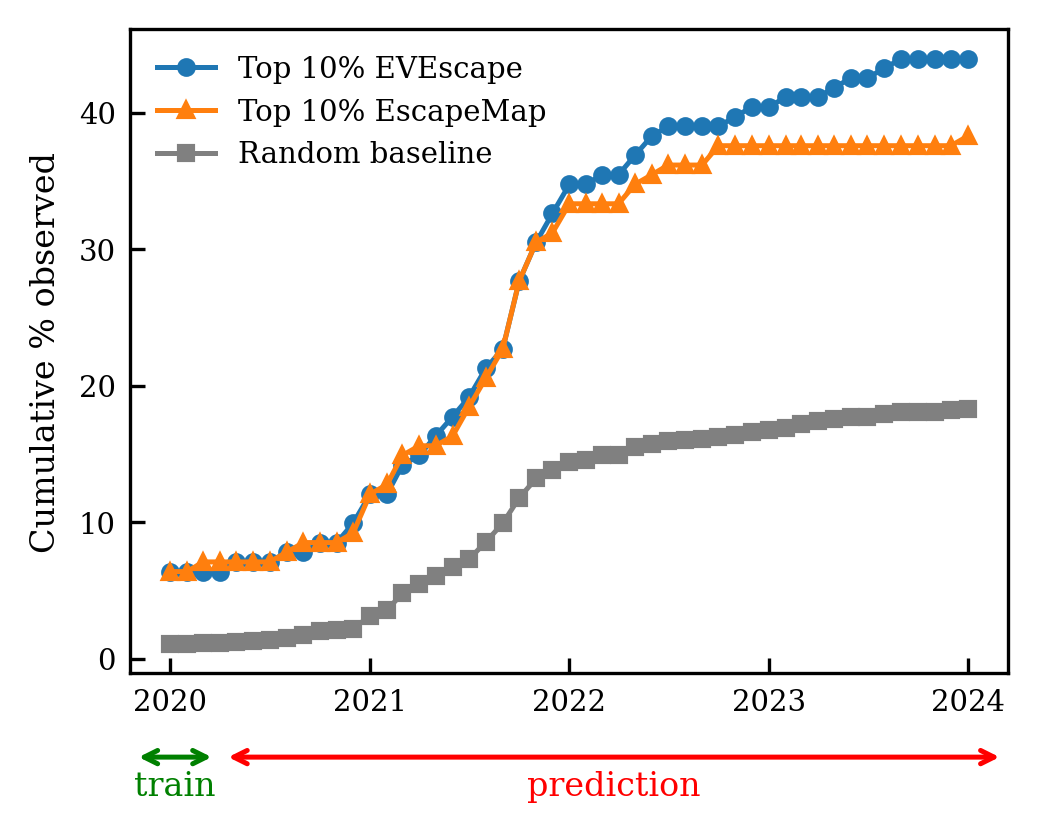

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates

# --- Load base ---
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")
df_base.loc[df_base['count'] < 100, 'first_seen_100'] = pd.NaT  # mask low-count dates

th = 90  # percentile threshold

# ---------- Prepare frames (single pass, no seeds) ----------
df = df_base.copy()

# load EscapeMap scores
col_em = "score" if "score" in df_em.columns else "scores"
df["escapemap"] = df_em[col_em].values

print(f"Test set size = {len(df)}")

# thresholds
thr_eve = np.nanpercentile(df["evescape"], th)
thr_em  = np.nanpercentile(df["escapemap"], th)

# subsets (top 100-th % for each scoring scheme)
top_eve = df[df["evescape"]   >= thr_eve].copy()
top_em  = df[df["escapemap"]  >= thr_em].copy()

# drop NaT
with_seen_eve = top_eve.dropna(subset=["first_seen_100"]).copy()
with_seen_em  = top_em.dropna(subset=["first_seen_100"]).copy()

# ---------- Global month axis ----------
mins, maxs = [], []
for x in (with_seen_eve, with_seen_em):
    if not x.empty:
        mins.append(x["first_seen_100"].min())
        maxs.append(x["first_seen_100"].max())

if not mins or not maxs:
    raise RuntimeError("No valid dates found after filtering; check inputs.")

global_start = min(mins)
global_end   = max(maxs)
global_months = pd.date_range(global_start, global_end, freq="MS")

def cum_frac(seen_df, denom, months):
    if denom == 0 or seen_df.empty:
        return np.zeros(len(months), dtype=float)
    dates = np.sort(seen_df["first_seen_100"].to_numpy("datetime64[ns]"))
    months64 = months.to_numpy("datetime64[ns]")
    counts = np.searchsorted(dates, months64, side="right")
    return (counts / denom) * 100.0

# ---------- Curves on common axis ----------
tot_eve, tot_em = len(top_eve), len(top_em)
avg_eve = cum_frac(with_seen_eve, tot_eve, global_months)
avg_em  = cum_frac(with_seen_em,  tot_em,  global_months)

# random: percentage of total mutations that appeared in pandemic
seen_all = df_base.dropna(subset=["first_seen_100"]).copy()
avg_rnd = cum_frac(seen_all, len(df_base), global_months)

# --- Plot (single curves, no seed averaging) ---
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))

ax.plot(global_months, avg_eve, marker="o", label=f"Top {100-th}% EVEscape")
ax.plot(global_months, avg_em,  marker="^", label=f"Top {100-th}% EscapeMap")
ax.plot(global_months, avg_rnd, marker="s", label="Random baseline", color="gray")

# X axis: yearly ticks
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.tick_params(axis="x", labelrotation=0)

ax.set_ylabel("Cumulative % observed")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)

# --- Train/prediction arrows placed lower ---
x0_num, x1_num = ax.get_xlim()
x0 = mdates.num2date(x0_num)
x1 = mdates.num2date(x1_num)
mid = train_date

y = -0.13
xf = ax.get_xaxis_transform()  # data x, axes-fraction y

ax.annotate("", xy=(mid, y), xytext=(x0, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="green"), annotation_clip=False)
cx_train = mdates.num2date((mdates.date2num(x0) + mdates.date2num(mid)) / 2)
ax.text(cx_train, y - 0.02, "train", color="green", ha="center", va="top",
        transform=xf, clip_on=False)

ax.annotate("", xy=(x1, y), xytext=(mid, y),
            xycoords=("data", "axes fraction"), textcoords=("data", "axes fraction"),
            arrowprops=dict(arrowstyle="<->", lw=1.2, color="red"), annotation_clip=False)
cx_pred = mdates.num2date((mdates.date2num(mid) + mdates.date2num(x1)) / 2)
ax.text(cx_pred, y - 0.02, "prediction", color="red", ha="center", va="top",
        transform=xf, clip_on=False)

plt.show()


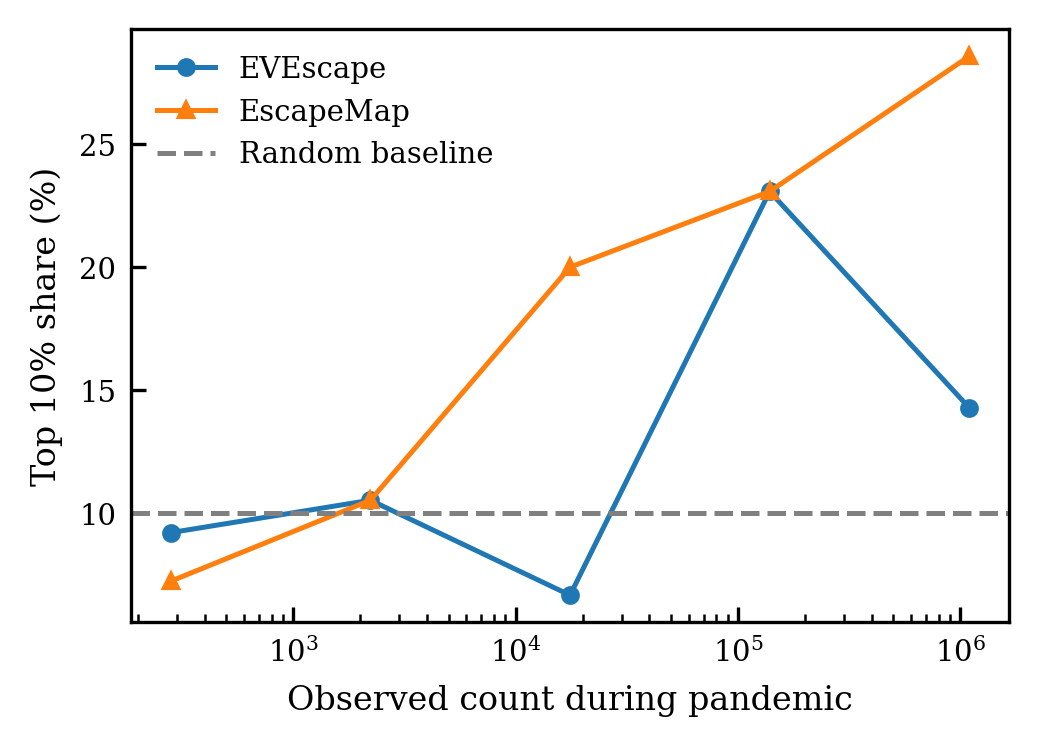

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# ----------------- Params -----------------
NB_EDGES = 6           # number of log-space edges => NB_EDGES-1 bins
th = 90                # percentile threshold (top 5%)

# ----------------- Load & restrict to RBD -----------------
df_base = pd.read_csv("rbd_dist_one_scores_gisaid.csv")
df_base = df_base[(df_base['i'] >= 349) & (df_base['i'] <= 526)].copy()
df_base['first_seen_100'] = pd.to_datetime(df_base['first_seen_100'], format="%Y-%m", errors="coerce")

# Use same EscapeMap data as previous plot
col_em = "score" if "score" in df_em.columns else "scores"
df_base["escapemap"] = df_em[col_em].values
df_base['test'] = np.where(df_base['first_seen_100'] > train_date, 1, 0)

df_base=df_base[df_base['test']==1]
# Parse first_seen and pandemic window
df_base["first_seen_dt"] = pd.to_datetime(df_base["first_seen_100"], format="%Y-%m", errors="coerce")

pandemic_start = pd.Timestamp("2020-01-01")
pandemic_end   = pd.Timestamp("2026-01-01")  # exclusive
obs = df_base[(df_base["first_seen_dt"] >= pandemic_start) & (df_base["first_seen_dt"] < pandemic_end)].copy()

# ----------------- Build log-spaced frequency bins -----------------
freq = pd.to_numeric(obs["count"], errors="coerce").fillna(0).astype(float)
freq_clip = np.clip(freq.values, 1.0, None)   # clip zeros to 1 for binning

lo, hi = float(freq_clip.min()), float(freq_clip.max())
if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
    raise ValueError("Frequency range invalid; cannot create log bins.")

edges_log = np.linspace(np.log10(lo), np.log10(hi), NB_EDGES)
edges = 10.0 ** edges_log
midpoints = np.sqrt(edges[:-1] * edges[1:])  # geometric mean per bin

# Precompute bin masks for obs
bin_masks = []
for i in range(NB_EDGES - 1):
    left, right = edges[i], edges[i+1]
    if i < NB_EDGES - 2:
        bin_mask = (freq_clip >= left) & (freq_clip < right)
    else:
        bin_mask = (freq_clip >= left) & (freq_clip <= right)
    bin_masks.append(bin_mask)

# ----------------- Helper -----------------
def share_top_decile(values, threshold, base_mask):
    n = int(base_mask.sum())
    if n == 0:
        return np.nan
    return 100.0 * np.sum(values[base_mask] >= threshold) / n

# ----------------- Thresholds on FULL RBD set (seedless) -----------------
thr_eve_global = np.nanpercentile(df_base["evescape"], th)
thr_em_global  = np.nanpercentile(df_base["escapemap"], th)

# Values aligned to obs
eve_vals_obs = df_base.loc[obs.index, "evescape"].values
em_vals_obs  = df_base.loc[obs.index, "escapemap"].values

# ----------------- Per-bin shares (no test mask, no seeds) -----------------
eve_curve = []
em_curve  = []
for bin_mask in bin_masks:
    eve_curve.append(share_top_decile(eve_vals_obs, thr_eve_global, bin_mask))
    em_curve.append( share_top_decile(em_vals_obs,  thr_em_global,  bin_mask))

eve_curve = np.array(eve_curve, dtype=float)
em_curve  = np.array(em_curve,  dtype=float)

# ----------------- Random baseline -----------------
random_baseline = 100 - th  # e.g., 5 for top-5%

# ----------------- Plot -----------------
mpl.rcParams.update({
    "figure.dpi": 300, "savefig.dpi": 600,
    "axes.linewidth": 0.8, "lines.linewidth": 1.2, "lines.markersize": 3.5,
    "font.size": 8, "axes.labelsize": 8, "xtick.labelsize": 7, "ytick.labelsize": 7,
    "legend.fontsize": 7, "font.family": "serif", "mathtext.fontset": "stix",
    "pdf.fonttype": 42, "ps.fonttype": 42,
})

fig, ax = plt.subplots(figsize=(3.375, 2.4))
x = midpoints

line_eve, = ax.plot(x, eve_curve, marker="o", label="EVEscape")
line_em,  = ax.plot(x, em_curve,  marker="^", label="EscapeMap")

ax.axhline(random_baseline, linestyle="--", label="Random baseline", color="grey")

ax.set_xscale("log")
ax.set_xlabel("Observed count during pandemic")
ax.set_ylabel("Top "+str(100-th)+"% share (%)")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()


<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\.'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\.'
C:\Users\maria\AppData\Local\Temp\ipykernel_3824\9758881.py:28: SyntaxWarning: invalid escape sequence '\d'
  key=lambda p: re.search(f"_{tag}_(\d{{4}}-\d{{2}})\.csv$", p).group(1) if re.search(f"_{tag}_(\d{{4}}-\d{{2}})\.csv$", p) else p
C:\Users\maria\AppData\Local\Temp\ipykernel_3824\9758881.py:28: SyntaxWarning: invalid escape sequence '\d'
  key=lambda p: re.search(f"_{tag}_(\d{{4

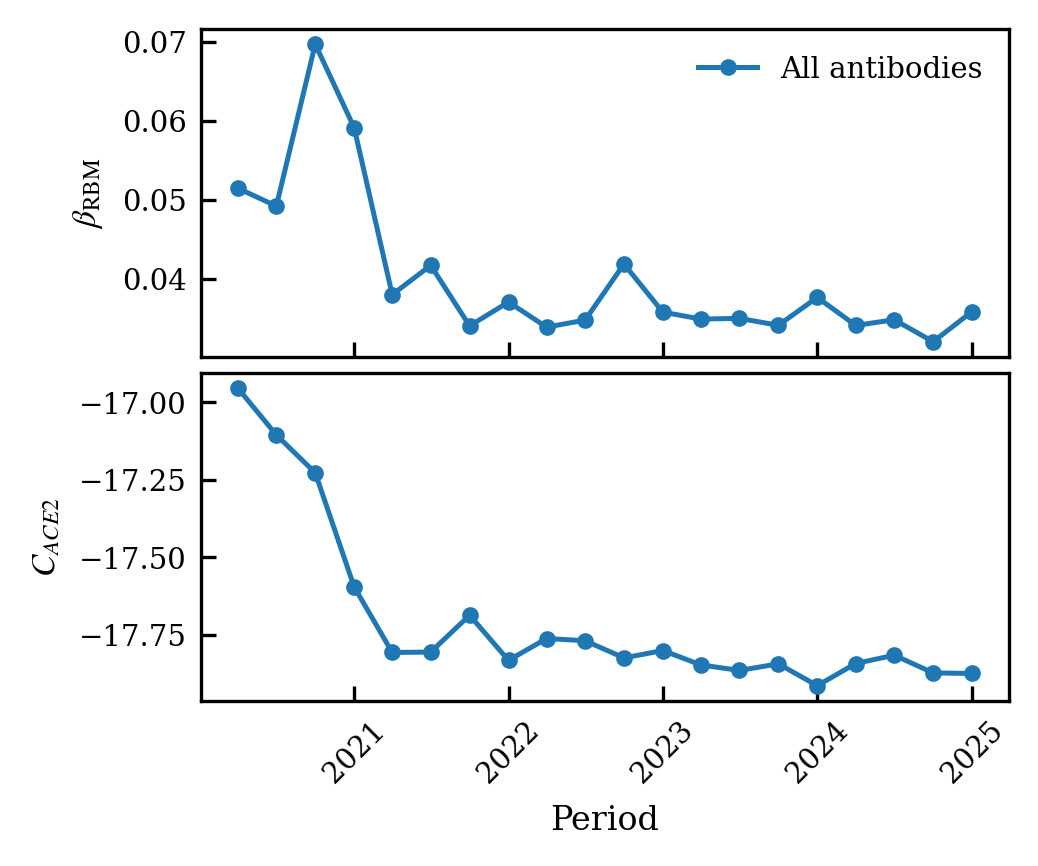

In [7]:
import glob, re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
# --- style (same as before) ---
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "lines.markersize": 3.0,
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})
# --- load per-period params and compute metrics ---
def load_metrics(tag, prefix="sigmoid_diff"):
    # FIX: Regex pattern corrected to match the actual file format
    files = sorted(
        glob.glob(f"results_periods_smaller_training/params_{prefix}_{tag}_*.csv"),
        key=lambda p: re.search(f"_{tag}_(\d{{4}}-\d{{2}})\.csv$", p).group(1) if re.search(f"_{tag}_(\d{{4}}-\d{{2}})\.csv$", p) else p
    )
    rows = []
    for fp in files:
        df = pd.read_csv(fp)
        if "period" not in df.columns:
            continue
        rc_cols = [c for c in df.columns if c.startswith("raw_c_")]
        if not rc_cols:
            continue
        df["beta_rbm"] = np.exp(df["raw_beta"])
        df["period_dt"] = pd.to_datetime(df["period"], format="%Y-%m", errors="coerce")
        df["tag"] = tag
        rows.append(df[["period_dt", "beta_rbm", "raw_ace2", "tag"]])
    if rows:
        out = pd.concat(rows, ignore_index=True)
        out = out.dropna(subset=["period_dt"]).sort_values("period_dt")
        return out
    return pd.DataFrame(columns=["period_dt", "beta_rbm", "raw_ace2", "tag"])
# choose which antibody sets to plot
tags = ["allab"]
loaded = {tag: load_metrics(tag) for tag in tags}
data = {tag: df for tag, df in loaded.items() if not df.empty}
if not data:
    raise RuntimeError("No params files found in results_periods_smaller_training/ for given tags.")
# --- filter start date ---
START_DT = pd.Timestamp("2020-04-01")
END_DT = pd.Timestamp("2025-01-01")
for tag in list(data.keys()):
    df = data[tag]
    mask = (df["period_dt"] >= START_DT) & (df["period_dt"] <= END_DT)
    data[tag] = df[mask]
# --- plotting (2 panels, no mean Ab) ---
fig, axes = plt.subplots(2, 1, figsize=(3.375, 2.8), sharex=True)
markers = {"allab": "o", "4ab": "^"}
labels = {"allab": "All antibodies", "4ab": "4 Ab"}
for tag, dfp in data.items():
    axes[0].plot(dfp["period_dt"], dfp["beta_rbm"], marker=markers.get(tag, "o"), label=labels.get(tag, tag))
    axes[1].plot(dfp["period_dt"], dfp["raw_ace2"], marker=markers.get(tag, "o"), label=labels.get(tag, tag))
axes[0].set_ylabel(r"$\beta_{\mathrm{RBM}}$")
axes[1].set_ylabel(r"$C_{ACE2}$")
axes[1].set_xlabel("Period")
for ax in axes:
    ax.tick_params(direction="in", which="both", top=False, right=False)
for lab in axes[1].get_xticklabels():
    lab.set_rotation(45)
# legend on top subplot
axes[0].legend(frameon=False, loc="best")
fig.tight_layout(pad=0.5)
plt.show()

['results_periods_smaller_training\\params_sigmoid_diff_allab_2020-04.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2020-07.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2020-10.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2021-01.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2021-04.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2021-07.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2021-10.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2022-01.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2022-04.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2022-07.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2022-10.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2023-01.csv', 'results_periods_smaller_training\\params_sigmoid_diff_allab_2023-04.csv', 'results_periods_smaller

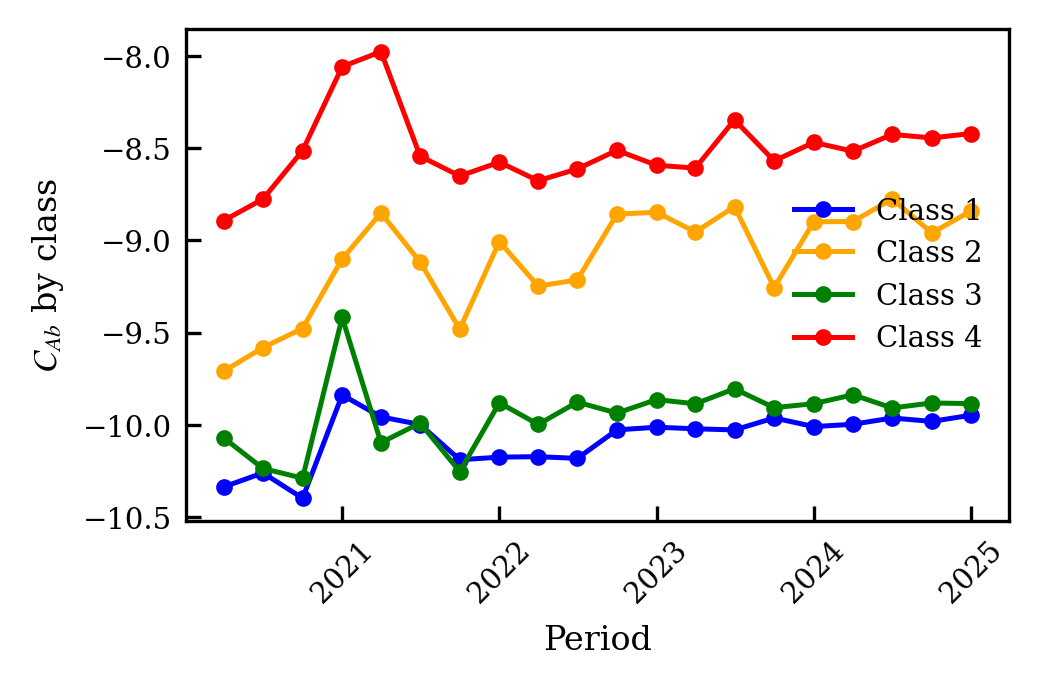

In [8]:
import glob, re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# --- style ---
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "lines.markersize": 3.0,
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# --- helpers ---
def load_ab_class_map(path="../exp_data/ab_classification.csv"):
    m = pd.read_csv(path)
    m["condition"] = m["condition"].astype(str)
    m["class_num"] = m["condition_subtype"].astype(str).str.extract(r"(\d+)").astype(int)
    return dict(zip(m["condition"], m["class_num"]))

def detect_tag(prefix="sigmoid_diff"):
    files = glob.glob(f"results_periods_smaller_training/params_{prefix}_*.csv")
    if not files:
        raise RuntimeError("No params files found.")
    tags = sorted({re.search(rf"params_{prefix}_(.+?)", f).group(1) for f in files})
    # prefer 'allab' if present
    return "allab" if "allab" in tags else tags[0]

def load_mean_rawc_by_class(tag, class_map, prefix="sigmoid_diff"):
    # Corrected regex pattern using a raw f-string for proper backslash handling
    regex_pattern = rf"_{tag}_(\d{{4}}-\d{{2}})\.csv$"
    
    files = sorted(
        glob.glob(f"results_periods_smaller_training/params_{prefix}_{tag}_*.csv"),
        key=lambda p: re.search(regex_pattern, p).group(1) if re.search(regex_pattern, p) else p
    )
 
    print(files)
    rows = []
    for fp in files:
        dfp = pd.read_csv(fp)
        if dfp.empty or "period" not in dfp.columns:
            continue
        rc_cols = [c for c in dfp.columns if c.startswith("raw_c_")]
        if not rc_cols:
            continue
        ab_names = [c.replace("raw_c_", "", 1) for c in rc_cols]
        # group antibody columns by class
        class_cols = {1: [], 2: [], 3: [], 4: []}
        for col, ab in zip(rc_cols, ab_names):
            cls = class_map.get(ab)
            if cls in class_cols:
                class_cols[cls].append(col)
        period_dt = pd.to_datetime(dfp.loc[0, "period"], format="%Y-%m", errors="coerce")
        for cls in (1, 2, 3, 4):
            cols = class_cols[cls]
            mean_val = float(dfp[cols].mean(axis=1).iloc[0]) if cols else np.nan
            rows.append({"period_dt": period_dt, "class": cls, "mean_raw_c": mean_val})
            
    if rows:
        out = pd.DataFrame(rows).dropna(subset=["period_dt"]).sort_values(["period_dt", "class"])
        return out
    
    return pd.DataFrame(columns=["period_dt", "class", "mean_raw_c"])

# --- load data ---
prefix = "sigmoid_diff"
tag = detect_tag(prefix=prefix)
class_map = load_ab_class_map("../exp_data/ab_classification.csv")
mc = load_mean_rawc_by_class('allab', class_map=class_map, prefix=prefix)

# --- date filter ---
START_DT = pd.Timestamp("2020-04-01")
END_DT   = pd.Timestamp("2025-01-01")
mc = mc[(mc["period_dt"] >= START_DT) & (mc["period_dt"] <= END_DT)]

# --- plot: mean raw_c by class over period ---
cls_colors = {1: "blue", 2: "orange", 3: "green", 4: "red"}

fig, ax = plt.subplots(figsize=(3.375, 2.2))
for cls in (1, 2, 3, 4):
    dfc = mc[mc["class"] == cls].sort_values("period_dt")
    if dfc.empty:
        continue
    ax.plot(dfc["period_dt"], dfc["mean_raw_c"], marker="o", label=f"Class {cls}", color=cls_colors[cls])

ax.set_xlabel("Period")
ax.set_ylabel(r"$C_{Ab}$ by class")
ax.tick_params(direction="in", which="both", top=False, right=False)
for lab in ax.get_xticklabels():
    lab.set_rotation(45)
ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()

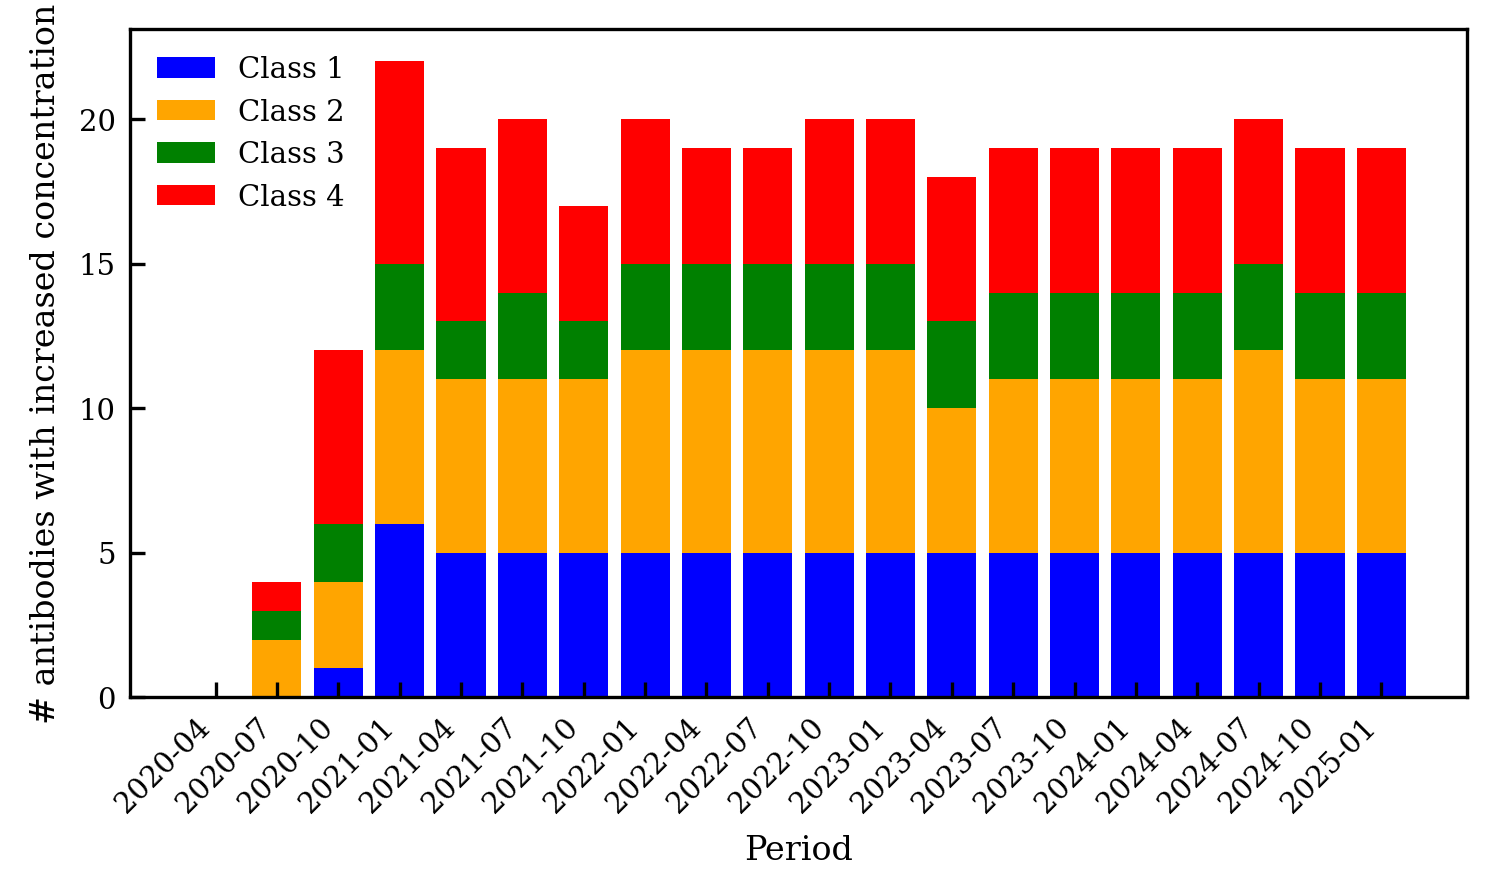

In [32]:
import glob, re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# --- style ---
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.linewidth": 0.8,
    "lines.linewidth": 1.2,
    "lines.markersize": 3.0,
    "font.size": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "font.family": "serif",
    "mathtext.fontset": "stix",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# --- helpers ---
def load_ab_class_map(path="../exp_data/ab_classification.csv"):
    m = pd.read_csv(path)
    m["condition"] = m["condition"].astype(str)
    m["class_num"] = m["condition_subtype"].astype(str).str.extract(r"(\d+)").astype(int)
    return dict(zip(m["condition"], m["class_num"]))

def detect_tag(prefix="sigmoid_diff"):
    files = glob.glob(f"results_periods_smaller_training/params_{prefix}_*.csv")
    if not files:
        raise RuntimeError("No params files found.")
    tags = sorted({re.search(rf"params_{prefix}_(.+?)_\d{{4}}-\d{{2}}\.csv$", f).group(1)
                   for f in files if re.search(rf"params_{prefix}_(.+?)_\d{{4}}-\d{{2}}\.csv$", f)})
    return "allab" if "allab" in tags else tags[0]

def load_rawc_long(tag, class_map, prefix="sigmoid_diff"):
    """Return long DF: period_dt, ab, class, raw_c."""
    regex_pattern = rf"_{tag}_(\d{{4}}-\d{{2}})\.csv$"
    files = sorted(
        glob.glob(f"results_periods_smaller_training/params_{prefix}_{tag}_*.csv"),
        key=lambda p: re.search(regex_pattern, p).group(1) if re.search(regex_pattern, p) else p
    )
    rows = []
    for fp in files:
        m = re.search(regex_pattern, fp)
        period_dt = pd.to_datetime(m.group(1), format="%Y-%m") if m else pd.NaT
        dfp = pd.read_csv(fp)
        rc_cols = [c for c in dfp.columns if c.startswith("raw_c_")]
        if not rc_cols:
            continue
        for col in rc_cols:
            ab = col.replace("raw_c_", "", 1)
            cls = class_map.get(ab)
            if cls not in (1, 2, 3, 4):
                continue
            val = float(dfp[col].iloc[0])
            rows.append({"period_dt": period_dt, "ab": ab, "class": cls, "raw_c": val})
    out = pd.DataFrame(rows).dropna(subset=["period_dt"])
    return out.sort_values(["period_dt", "ab"]).reset_index(drop=True)

# --- load ---
prefix = "sigmoid_diff"
tag = detect_tag(prefix=prefix)
class_map = load_ab_class_map("../exp_data/ab_classification.csv")
df_long = load_rawc_long(tag, class_map=class_map, prefix=prefix)

# --- date filter ---
START_DT = pd.Timestamp("2020-04-01")
END_DT   = pd.Timestamp("2025-01-01")
df_long = df_long[(df_long["period_dt"] >= START_DT) & (df_long["period_dt"] <= END_DT)].copy()

# --- baseline per antibody: first period value ---
df_first = df_long.sort_values(["ab", "period_dt"]).drop_duplicates("ab", keep="first")
baseline = df_first.set_index("ab")["raw_c"]
df_long["baseline_raw_c"] = df_long["ab"].map(baseline)

# flag increase vs first period
df_long["increased"] = (df_long["raw_c"] > df_long["baseline_raw_c"]+np.log10(2)).astype(int)

# --- counts per period and class ---
counts = (df_long.groupby(["period_dt", "class"])["increased"].sum()
          .unstack("class").fillna(0).astype(int))
# ensure class columns 1..4 exist
for cls in (1, 2, 3, 4):
    if cls not in counts.columns:
        counts[cls] = 0
counts = counts.sort_index()
counts = counts[[1, 2, 3, 4]]  # column order

# --- plot: stacked bars by class ---
cls_colors = {1: "blue", 2: "orange", 3: "green", 4: "red"}

fig, ax = plt.subplots(figsize=(4.9, 2.9))
bottom = np.zeros(len(counts), dtype=float)
x = np.arange(len(counts))

for cls in (1, 2, 3, 4):
    vals = counts[cls].to_numpy()
    ax.bar(x, vals, bottom=bottom, label=f"Class {cls}", color=cls_colors[cls])
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(counts.index.strftime("%Y-%m"), rotation=45, ha="right")
ax.set_ylabel("# antibodies with increased concentration")
ax.set_xlabel("Period")
ax.tick_params(direction="in", which="both", top=False, right=False)
ax.legend(frameon=False, loc="best")

fig.tight_layout(pad=0.5)
plt.show()
